In [3]:
import nibabel as nib
from tqdm import tqdm   
from skimage import morphology
from scipy import ndimage
from PIL import Image
import numpy as np
depth = 32
def normalize(volume, norm_type):
    if norm_type == 'zero_mean':
        img_o = np.float32(volume.copy())
        m = np.mean(img_o)
        s = np.std(img_o)
        volume = np.divide((img_o - m), s)
    elif norm_type == 'div_by_max':
        volume = np.divide(volume, np.percentile(volume,98))
        
    elif norm_type == 'onezero':
        for channel in range(volume.shape[-1]):
            volume_temp = volume[..., channel]
            volume_temp = (volume_temp - np.min(volume_temp)) / (np.max(volume_temp)-np.min(volume_temp))

            volume[..., channel] = volume_temp
    volume = volume.astype("float32")
    return volume

def resize_volume(img,size,depth):
    """Resize across z-axis"""
    # Set the desired depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    img = ndimage.zoom(img, (size/current_height, size/current_width, 1), order=0)
    return img

def process_scan(path, size):
# get nib first channel
    try:
        image = nib.load(path)
        affine = image.header.get_best_affine()
        # print(affine)
        # print(image.shape)
        if len(image.shape) == 4:
            image = image.get_fdata()
            width,height,queue,_ = image.shape
            image = image[:,:,:,1]
            image = np.reshape(image,(width,height,queue))
        else:
            image = image.get_fdata()
            pass
        if affine[1, 1] > 0:
            image = ndimage.rotate(image, 90, reshape=False, mode="nearest")
        if affine[1, 1] < 0:
            image = ndimage.rotate(image, -90, reshape=False, mode="nearest")

        volume = normalize(image,"zero_mean")
        volume = resize_volume(volume,size,depth)
    #   add only black background mri image
        if volume.shape[2]!=depth:
            add_black_num = depth - volume.shape[2]
            volume = volume.transpose(2,0,1)
            for i in range(add_black_num):
                add_black_ = np.expand_dims(np.zeros((volume.shape[2],volume.shape[2])),axis=0)
                volume = np.concatenate((volume, add_black_), axis = 0)
            volume = volume.transpose(1,2,0)
        volume = volume.transpose(2,0,1)
        # print(volume.shape)
        if affine[0, 0] < 0:
            for i in range(volume.shape[0]):
                volume[i,:,:] = np.fliplr(volume[i,:,:])

    except:
        pass
        print(path)
        volume = image = np.zeros((size,size,depth))
    return volume
def mask_scan(path,size):
# get nib first channel
    # try:
    image = nib.load(path)
    affine = image.header.get_best_affine()
    if len(image.shape) == 4:
        image = image.get_fdata()
        width,height,queue,_ = image.shape
        image = image[:,:,:,1]
        image = np.reshape(image,(width,height,queue))
    else:
        image = image.get_fdata()
        pass
    if affine[1, 1] > 0:
        image = ndimage.rotate(image, 90, reshape=False, mode="nearest")
    if affine[1, 1] < 0:
        image = ndimage.rotate(image, -90, reshape=False, mode="nearest")
    # print(affine)
    image = resize_volume(image,size,depth)
    shape = image.shape
#   add only black background mri image
    
    if image.shape[2]!=depth:
        add_black_num = depth - image.shape[2]
        image = image.transpose(2,0,1)
        for i in range(add_black_num):
            add_black_ = np.expand_dims(np.zeros((image.shape[2],image.shape[2])),axis=0)
            image = np.concatenate((image, add_black_), axis = 0)
        image = image.transpose(1,2,0)
    image = image.transpose(2,0,1)
    # print(image.shape)
    if affine[0, 0] < 0:
        for i in range(image.shape[0]):
            image[i,:,:] = np.fliplr(image[i,:,:])
    # except:
    #     pass
    #     image = np.zeros((size,size,depth))
    #     print(path)
    return image

In [5]:

# path = {your path}
path = '/ssd1/dataset_stack//MRI dataset//isXXXX_all_mask_and_image_check/3.0T_test'
img_stack = []
msg_stack = []
for  i in tqdm(os.listdir(path)):
    if 'o.nii' in i:
        # build MRI raw data
        img = process_scan(f'{path}/{i}',384)
        img_stack.append(img)
        # build MRI seg data
    else:
        seg = mask_scan(f'{path}/{i}',384)
        msg_stack.append(seg)
# np.save(f'./dataset/test/{i}o', img)
# np.save(f'./dataset/test/{i}s', seg)

100%|██████████| 90/90 [00:29<00:00,  3.10it/s]


In [8]:
img_stack = np.array(img_stack.copy())
msg_stack = np.array(msg_stack.copy())

In [12]:
np.save("./demo/image_arr_3.0T_384_test.npy" ,img_stack)
np.save("./demo/mask_arr_3.0T_384_test.npy" ,msg_stack)

In [13]:
img_stack = np.load('./demo/image_arr_3.0T_384_test.npy')
img_stack.shape

(45, 32, 384, 384)

In [11]:
# for i in datalist
i = 'is0323'
# path = {your path}
path = '/ssd1/dataset_stack//MRI dataset//isXXXX_all_mask_and_image_check//3.0T_test//'
# build MRI raw data
img = process_scan(f'{path}/{i}o.nii.gz',384)
# build MRI seg data
seg = mask_scan(f'{path}/{i}s.nii.gz',384)
print(img.shape, seg.shape)
# np.save(f'./dataset/test/{i}o', img)
# np.save(f'./dataset/test/{i}s', seg)

[[-5.72916687e-01  0.00000000e+00  0.00000000e+00  1.10000008e+02]
 [ 0.00000000e+00 -5.72023374e-01 -3.90750832e-01  1.20678360e+02]
 [ 0.00000000e+00 -3.19810742e-02  6.98909011e+00  2.91405106e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(32, 384, 384) (32, 384, 384)


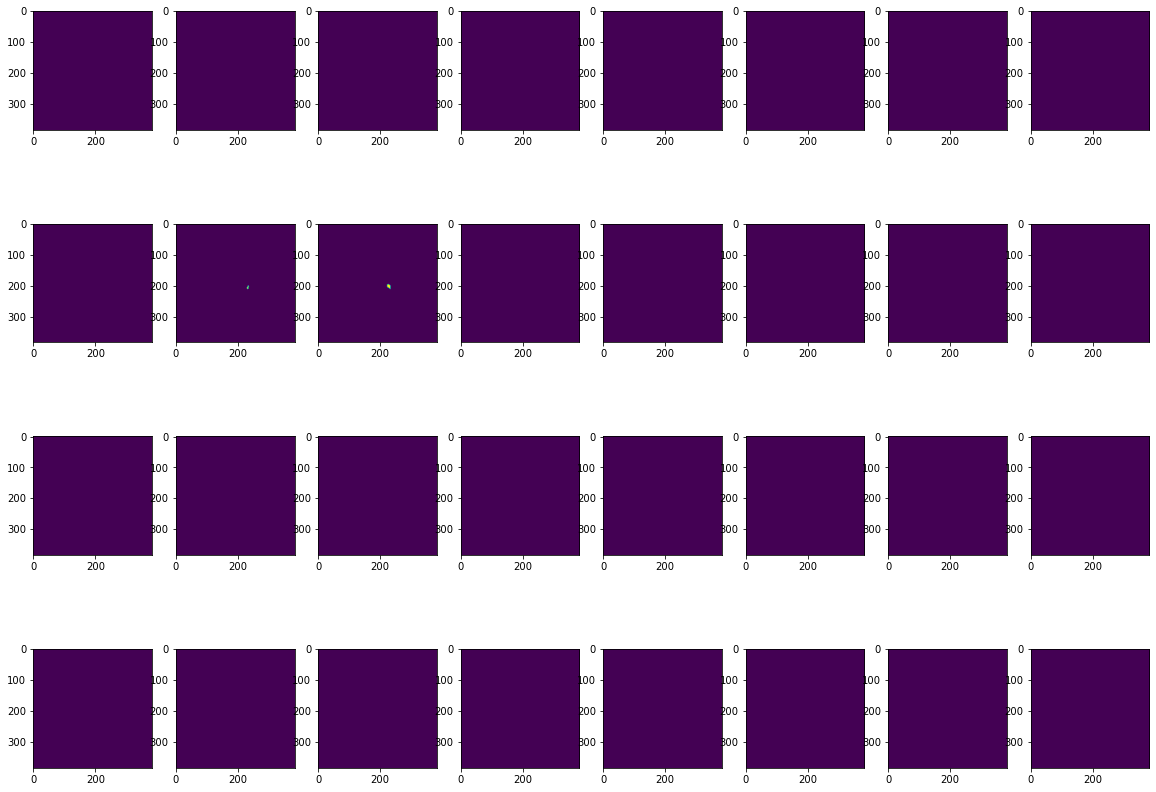

In [12]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(4, 8, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip(seg, axs):
    ax.imshow(img)
plt.show()

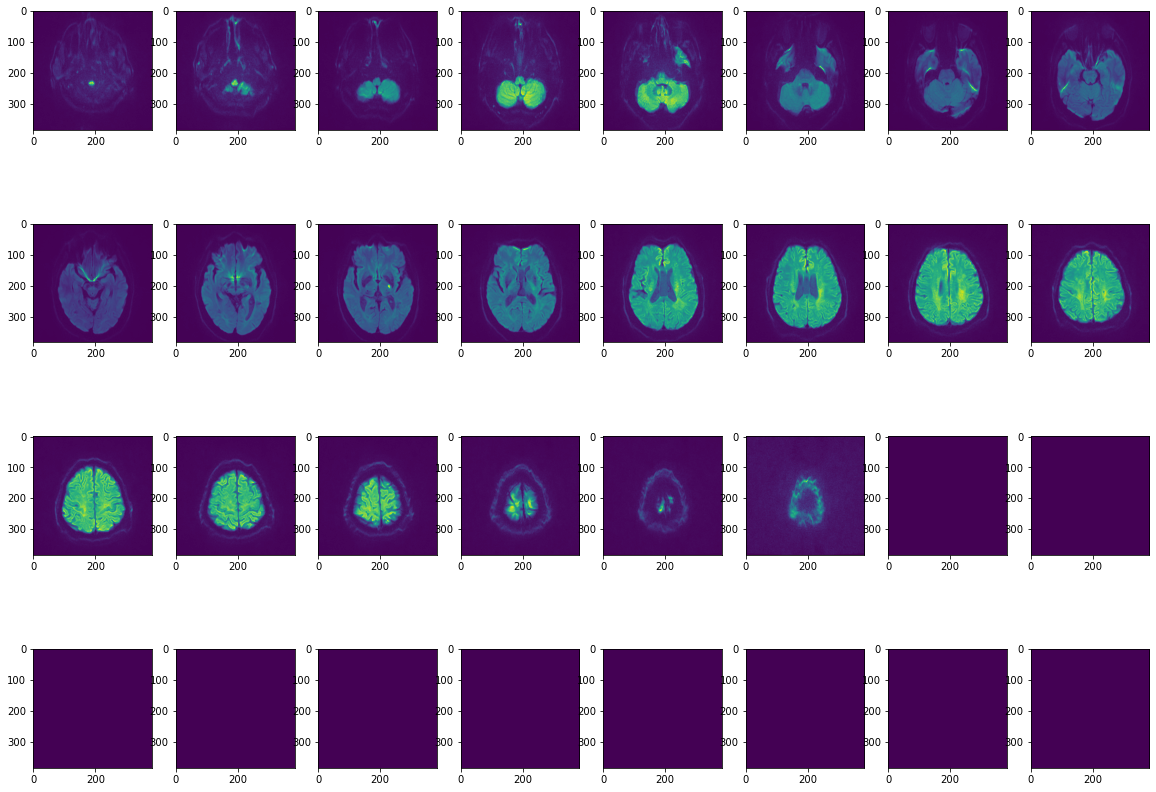

In [9]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(4, 8, figsize=(20, 15))
axs = axs.flatten()
for img, ax in zip(img, axs):
    ax.imshow(img)
plt.show()

In [3]:
# Build random data array
sample_size = 10
width = 384
height = 384
depth = 32
img_data = np.random.rand(sample_size, depth, width, height)
img_seg = np.random.randint(2, size = (sample_size, depth, width, height))
img_label = np.random.randint(2, size = (sample_size))
print(img_data.shape, img_seg.shape, img_label.shape)
np.save(f'./dataset/rand_test/T3_image_arr_384_valid', img_data)
np.save(f'./dataset/rand_test/T3_masks_arr_384_valid', img_seg)
np.save(f'./dataset/rand_test/T3_0_onehot_valid', img_label)

(10, 32, 384, 384) (10, 32, 384, 384) (10,)
